Reference for model stacking: https://www.kaggle.com/zhixinzhang/stacked-regressions-top-4-on-leaderboard

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
%matplotlib inline

#from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from sklearn.svm import SVR
#from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from collections import defaultdict
from skopt.plots import plot_convergence

from scipy.stats import uniform, randint

#import xgboost as xgb
import lightgbm as lgb
import datetime

In [59]:
def diagnostic_stats(ytrue, ypred):
    """
    https://stats.stackexchange.com/questions/142248/difference-between-r-square-and-rmse-in-linear-regression
    
    https://www.sciencedirect.com/topics/engineering/mean-bias-error
    """
    n = len(ytrue)

    # Check that the ytrue and ypred are equal length vector.
    assert n == len(ypred)
    
    # sum squared error
    sse = np.sum((ytrue - ypred)**2)
    
    # root mean square error
    rmse = np.sqrt(sse/n)

    # total sum of squares
    tss = np.sum((ytrue - np.mean(ytrue))**2)
    tst = np.sum((ypred - np.mean(ypred))**2)
    tstp = tst**0.5
    tssp = tss**0.5
    
    soorat = np.sum((ytrue-np.mean(ytrue))*(ypred-np.mean(ypred)))
    
    # Rsquare
    ##rsqr = 1 - sse/tss
    rsqr = (soorat/(tssp*tstp))**2

    # Mean biased error
    mbe = np.mean(ytrue - ypred)
    
    # IOAD
    num = np.sum((ytrue - ypred)**2)
    denom = np.abs(ytrue - ypred) + np.abs(ytrue + ypred)
    ioad = 1 - num/np.sum(denom**2)

    print("RMSE: %1.3f, R^2: %1.3f, MBE: %1.3f, IOAD: %1.3f"%(rmse, rsqr, mbe, ioad))
    
    return rmse, rsqr, mbe, ioad

In [60]:
evidf = pd.read_csv('../data_out/Gingin_EVI_processed.csv', parse_dates=['DateTime'], index_col='DateTime')
evidf.head()

,EVI
DateTime,
2000-02-26 08:00:00,0.229511
2000-02-26 08:30:00,0.229519
2000-02-26 09:00:00,0.229526
2000-02-26 09:30:00,0.229534
2000-02-26 10:00:00,0.229541


In [61]:
tempdf = pd.read_csv('rnn_data_prajwal.csv', parse_dates=['DateTime'], index_col='DateTime')
tempdf.drop('Unnamed: 0', axis=1, inplace=True)

In [62]:
tempdf.head()

,Fc,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws
DateTime,,,,,,,,,
2013-01-01 01:00:00,3.070399,26.998711,2.08,-20.984654,1.183521,-39.635899,0.014801,32.291790,0.032662
2013-01-01 01:30:00,2.948313,26.629910,2.47,-19.131921,1.067606,-35.979652,0.015045,32.036301,0.032636
2013-01-01 02:00:00,2.369790,26.294310,1.95,-18.278720,1.002275,-38.033844,0.015030,31.798710,0.032619
2013-01-01 02:30:00,0.105580,25.739479,1.55,-17.862080,0.927464,-41.878986,0.014810,31.572710,0.032582
2013-01-01 03:30:00,2.085828,24.548740,2.69,-21.647482,0.792163,-57.483334,0.014242,31.069750,0.032534


In [63]:
df = pd.merge(tempdf, evidf, how='left', on='DateTime')

In [64]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 01:00:00'), Timestamp('2014-01-01 00:00:00'))

In [65]:
Xvar = ['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws', 'EVI']
yvar = 'Fc'

### Train-test splits
    1. Test: 60 days starting randomly picked date
    2. Train: Remaining data
        a. Layer 1 and Layer 2: 50:50 random split
        b. Layer 1 further divided into 1/m unique train sets, where m = number of unique models. 

In [66]:
df.index.date.min(), df.index.date.max()

(datetime.date(2013, 1, 1), datetime.date(2014, 1, 1))

In [67]:
# Test data set
# 60 days window starting from randomly picked day.

np.random.seed(41)

interval = 60

if (df.index.date.max() - df.index.date.min()).days < interval:
    raise ValueError(f'Gap is longer than max-min date interval of the dataset.')

test_end_day = pd.to_datetime('2100-01-01', format='%Y-%M-%d') # arbitrarily large back date
while test_end_day > df.index.date.max():
    test_start_day = np.random.choice(df.index.date, 1)[0]
    test_end_day = test_start_day + datetime.timedelta(days=interval)

print('Test start date:', test_start_day)
print('Test end date:', test_end_day)

Test start date: 2013-03-21
Test end date: 2013-05-20


In [68]:
df_test = df.loc[test_start_day:test_end_day].copy()
df_train = pd.concat([df.loc[:test_start_day], df.loc[test_end_day:]]).copy()

# Scaling test frame
y_test_mean, y_test_std = df_test[yvar].mean(), df_test[yvar].std()
scaler_test = StandardScaler()
df_test[df_test.keys()] = scaler_test.fit_transform(df_test)

# Scaling train frame
y_train_mean, y_train_std = df_train[yvar].mean(), df_train[yvar].std()
scaler_train = StandardScaler()
df_train[df_train.keys()] = scaler_train.fit_transform(df_train)

In [69]:
print(df.loc[test_start_day:test_end_day].index.min(), '>', df.loc[:test_start_day].index.max())
print(df.loc[test_start_day:test_end_day].index.max(), '<',df.loc[test_end_day:].index.min())

assert df.loc[test_start_day:test_end_day].index.min() > df.loc[:test_start_day].index.max()
assert df.loc[test_start_day:test_end_day].index.max() < df.loc[test_end_day:].index.min()

2013-03-21 02:30:00 > 2013-03-20 21:00:00
2013-05-19 20:30:00 < 2013-05-20 06:00:00


In [70]:
X_test, y_test = df_test[Xvar], df_test[yvar]

In [71]:
#SEED, SEED2 = 40, 1
SEED, SEED2 = 20, 45
X_train_layer1, X_train_layer2, y_train_layer1, y_train_layer2 = train_test_split(df_train[Xvar], df_train[yvar], test_size=0.50, random_state=SEED, shuffle=True)

X_train1_layer1, X_rest1_layer1, y_train1_layer1, y_rest1_layer1 = train_test_split(X_train_layer1, y_train_layer1, test_size=5/6., random_state=SEED2, shuffle=True)
X_train2_layer1, X_rest2_layer1, y_train2_layer1, y_rest2_layer1 = train_test_split(X_rest1_layer1, y_rest1_layer1, test_size=4/5., random_state=SEED2, shuffle=True)
X_train3_layer1, X_rest3_layer1, y_train3_layer1, y_rest3_layer1 = train_test_split(X_rest2_layer1, y_rest2_layer1, test_size=3/4., random_state=SEED2, shuffle=True)
X_train4_layer1, X_rest4_layer1, y_train4_layer1, y_rest4_layer1 = train_test_split(X_rest3_layer1, y_rest3_layer1, test_size=2/3., random_state=SEED2, shuffle=True)
X_train5_layer1, X_train6_layer1,y_train5_layer1,y_train6_layer1 = train_test_split(X_rest4_layer1, y_rest4_layer1, test_size=1/2., random_state=SEED2, shuffle=True)

In [72]:
X_train_layer2

,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws,EVI,rank
DateTime,,,,,,,,,,
2013-11-08 19:30:00,-0.018705,-0.177995,-1.352843,-0.189344,-1.222090,0.053327,0.635752,-0.292979,0.106517,layer2_train
2013-11-26 07:00:00,-0.844949,-1.309812,-0.987536,-0.695380,-0.277958,-0.286506,-0.574670,-0.617560,-0.542570,layer2_train
2013-01-14 04:30:00,-0.213808,-1.515193,-0.646601,-1.490767,-0.901313,3.463311,0.100491,-0.270135,-0.478412,layer2_train
2013-01-06 12:30:00,2.058893,1.168716,1.916511,1.628831,1.419997,2.222908,0.937890,-0.792586,-0.451685,layer2_train
2013-11-17 15:30:00,0.814890,-0.405825,-0.069593,0.294164,0.966464,1.112675,0.979331,-0.496689,-0.226407,layer2_train
...,...,...,...,...,...,...,...,...,...,...
2013-06-04 13:30:00,-0.379598,-1.527111,0.667465,-0.151240,-0.119590,-0.931449,-1.420928,0.372892,0.677258,layer2_train
2013-07-26 18:30:00,-1.034513,0.999439,-0.683502,-0.682280,-1.108132,-0.676127,-1.078588,1.570472,0.375901,layer2_train
2013-02-01 18:30:00,1.458740,1.563408,-1.458870,1.514813,-0.867007,-0.141037,1.870460,-0.978022,-1.380438,layer2_train


In [73]:
print('Full', df.shape[0], '-->', 'Test:', df_test.shape[0], 'Train:', 
      df_train.shape[0], '-->', 'Train layer1: ', X_train_layer2.shape[0], 'Train layer2: ', X_train_layer1.shape[0]),
print('Train layer1 model splits: ', 
      X_train1_layer1.shape[0], 
      X_train2_layer1.shape[0], 
      X_train3_layer1.shape[0], 
      X_train4_layer1.shape[0], 
      X_train5_layer1.shape[0], 
      X_train6_layer1.shape[0])

Full 9015 --> Test: 1367 Train: 7648 --> Train layer1:  3824 Train layer2:  3824
Train layer1 model splits:  637 637 637 637 638 638


In [74]:
#Validation function
def rmsle_cv(model, X_train, y_train, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    clf = cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf)
    rmse= np.sqrt(-clf)
    return(rmse)

### Layer 1 training

In [75]:
N_FOLDS = 3
N_CALLS = 51
THRESHOLD = 0.05

In [76]:
### Custom cross-validation function: weighted F1 score on specific threshold

def objective_core(cls, Xtrain, ytrain, **params):
    """
    Objective function to minimize, using custom cross-validation. Default CV is limited 
    """

    # Update parameters with default parameters
    params = {**params, **{'n_jobs':-1}}    
    threshold = THRESHOLD # Evaluate for single point

    #cls_ = RandomForestRegressor(**params)
    cls_ = cls #lgb.LGBMRegressor(**params)
    print("------ Sampling new data point ------")

    kfold = KFold(n_splits=N_FOLDS, shuffle=True)
    cval_results = defaultdict(list)

    for train_index, test_index in kfold.split(Xtrain, ytrain):
        X_train_, X_test_ = Xtrain.iloc[train_index, :], Xtrain.iloc[test_index, :]
        y_train_, y_test_ = ytrain.iloc[train_index], ytrain.iloc[test_index]

        # Train regressor on current fold
        cls_.fit(X_train_, y_train_)
        y_test_predicted = cls_.predict(X_test_)

        cval_results['mse'].append(mean_squared_error(y_test_, y_test_predicted))

    score = np.mean(np.sqrt(cval_results['mse']))
    print("Params:",params)
    print("Score:", score)
    
    return score

##### 1a. Gradient Boosting Regression

In [102]:
model = lgb.LGBMRegressor()
params = {'n_estimators':10}
model.set_params(**params)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [89]:
params_space  = [Integer(2, 10, name='num_leaves'),
          Categorical(['regression'], name = "objective"),
          Integer(2, 10, name='min_data_in_leaf'),
          Real(10**-5, 10**0, "uniform", name='learning_rate'),
          Integer(100, 1000, name='n_estimators')]


@use_named_args(params_space)
def lgb_objective(**params):
    cls = lgb.LGBMRegressor(**params)
    return objective_core(cls, X_train1_layer1, y_train1_layer1, **params)

In [103]:
res_lgb = gp_minimize(lgb_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_lgb.fun

------ Sampling new data point ------
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.8472532662667378, 'n_estimators': 661, 'n_jobs': -1}
Score: 0.929961848494882
------ Sampling new data point ------
Params: {'num_leaves': 5, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.27266356801716746, 'n_estimators': 530, 'n_jobs': -1}
Score: 0.8493017729557951
------ Sampling new data point ------
Params: {'num_leaves': 8, 'objective': 'regression', 'min_data_in_leaf': 5, 'learning_rate': 0.8360804027497424, 'n_estimators': 404, 'n_jobs': -1}
Score: 0.9129660044901916
------ Sampling new data point ------
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.14035937690484107, 'n_estimators': 883, 'n_jobs': -1}
Score: 0.8515622902009229
------ Sampling new data point ------
Params: {'num_leaves': 6, 'objective': 'regression', 'min_data_in_leaf': 6, 'learning_rate': 0.6788827413236592,

------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 3, 'learning_rate': 0.08690131514142095, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.7645329137939852
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.08628274282273897, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.7548975757148585
------ Sampling new data point ------
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.08585804833747336, 'n_estimators': 1000, 'n_jobs': -1}
Score: 0.7922248386451272
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.08427257518027793, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.7471651727666387
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.093359770490

'Best score=0.7383'

In [233]:
print("Optimal parameters")
params_lgb = {}
for param, value in zip(params_space, res_lgb.x):
    print(f"Param: {param.name}, value: {value}")
    params_lgb[param.name] = value
    
model_lgb = lgb.LGBMRegressor(**params_lgb)
model_lgb.fit(X_train1_layer1.values, y_train1_layer1.values)

Optimal parameters
Param: num_leaves, value: 2
Param: objective, value: regression
Param: min_data_in_leaf, value: 10
Param: learning_rate, value: 0.1832501555621475
Param: n_estimators, value: 100


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1832501555621475,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=2, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

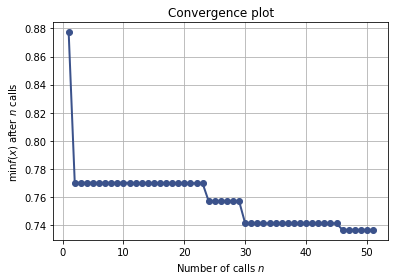

In [234]:
plt.figure()
plot_convergence(res_lgb)
plt.show()

##### 2. LASSO Regression

In [235]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =1e-4, random_state=1))
score = rmsle_cv(model_lasso, X_train2_layer1, y_train2_layer1, N_FOLDS)
print("\nLasso score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_lasso.fit(X_train2_layer1, y_train2_layer1);


Lasso score: 0.6997 (+/-0.0414)



##### 2b. Ridge regression

In [236]:
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.05, random_state=1))
score = rmsle_cv(model_ridge, X_train2_layer1, y_train2_layer1, N_FOLDS)
print("\nRidge score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_ridge.fit(X_train2_layer1, y_train2_layer1);


Ridge score: 0.6998 (+/-0.0414)



##### 3. Random Forest Estimator 

In [237]:
params_space  = [Integer(2, 25, name='max_depth'),
                 Integer(2, 15, name='min_samples_leaf'),
                 Integer(2, 15, name='min_samples_split'),
                 Integer(100, 1000, name='n_estimators')
                ]

@use_named_args(params_space)
def rfe_objective(**params):
    cls = RandomForestRegressor(**params)
    return objective_core(cls, X_train3_layer1, y_train3_layer1, **params)

In [238]:
res_rfe = gp_minimize(rfe_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_rfe.fun

------ Sampling new data point ------
Params: {'max_depth': 16, 'min_samples_leaf': 13, 'min_samples_split': 13, 'n_estimators': 863, 'n_jobs': -1}
Score: 0.6463496197791683
------ Sampling new data point ------
Params: {'max_depth': 16, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 151, 'n_jobs': -1}
Score: 0.6494127087509591
------ Sampling new data point ------
Params: {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 13, 'n_estimators': 532, 'n_jobs': -1}
Score: 0.6293577638830722
------ Sampling new data point ------
Params: {'max_depth': 11, 'min_samples_leaf': 13, 'min_samples_split': 6, 'n_estimators': 683, 'n_jobs': -1}
Score: 0.6376158868203441
------ Sampling new data point ------
Params: {'max_depth': 10, 'min_samples_leaf': 14, 'min_samples_split': 4, 'n_estimators': 883, 'n_jobs': -1}
Score: 0.6472806153443805
------ Sampling new data point ------
Params: {'max_depth': 13, 'min_samples_leaf': 12, 'min_samples_split': 9, 'n_estimators': 711, 'n_

/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1}
Score: 0.638904733841575
------ Sampling new data point ------
Params: {'max_depth': 22, 'min_samples_leaf': 15, 'min_samples_split': 7, 'n_estimators': 999, 'n_jobs': -1}
Score: 0.639116144374666
------ Sampling new data point ------
Params: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 103, 'n_jobs': -1}
Score: 0.6512922891894847
------ Sampling new data point ------
Params: {'max_depth': 25, 'min_samples_leaf': 14, 'min_samples_split': 14, 'n_estimators': 981, 'n_jobs': -1}
Score: 0.6239612107712044
------ Sampling new data point ------
Params: {'max_depth': 25, 'min_samples_leaf': 9, 'min_samples_split': 13, 'n_estimators': 999, 'n_jobs': -1}
Score: 0.6511632482309997
------ Sampling new data point ------
Params: {'max_depth': 22, 'min_samples_leaf': 14, 'min_samples_split': 14, 'n_estimators': 999, 'n_j

/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1}
Score: 0.6257311124174858
------ Sampling new data point ------
Params: {'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 101, 'n_jobs': -1}
Score: 0.640971153264036


/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1}
Score: 0.6579311481243301
------ Sampling new data point ------
Params: {'max_depth': 22, 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 1000, 'n_jobs': -1}
Score: 0.6383565746277747
------ Sampling new data point ------
Params: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 999, 'n_jobs': -1}
Score: 0.6562026624969505
------ Sampling new data point ------
Params: {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 995, 'n_jobs': -1}
Score: 0.6448911145043144
------ Sampling new data point ------
Params: {'max_depth': 23, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.640360409519753


/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1}
Score: 0.6369196236761425
------ Sampling new data point ------
Params: {'max_depth': 14, 'min_samples_leaf': 15, 'min_samples_split': 3, 'n_estimators': 982, 'n_jobs': -1}
Score: 0.646738692379373
------ Sampling new data point ------
Params: {'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 4, 'n_estimators': 105, 'n_jobs': -1}
Score: 0.6483546285258203
------ Sampling new data point ------
Params: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 113, 'n_jobs': -1}
Score: 0.6456210234390961
------ Sampling new data point ------
Params: {'max_depth': 23, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 992, 'n_jobs': -1}
Score: 0.6567024268382012
------ Sampling new data point ------
Params: {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 102, 'n_j

'Best score=0.6166'

In [239]:
print("Optimal parameters")
params_rfe = {}
for param, value in zip(params_space, res_rfe.x):
    print(f"Param: {param.name}, value: {value}")
    
    params_rfe[param.name] = value
    
model_rfe = RandomForestRegressor(**params_rfe)
model_rfe.fit(X_train3_layer1.values, y_train3_layer1.values)

Optimal parameters
Param: max_depth, value: 4
Param: min_samples_leaf, value: 8
Param: min_samples_split, value: 4
Param: n_estimators, value: 763


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=763,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

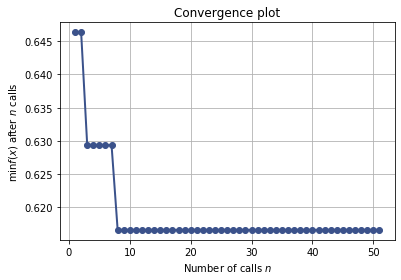

In [240]:
plt.figure()
plot_convergence(res_rfe)
plt.show()

##### 4. SVM

In [241]:
params_space  = [Integer(2, 6, name='degree'),
                 Categorical(['scale'], name='gamma'),
                 Categorical(['rbf', 'poly', 'sigmoid'], name='kernel'),
                 Real(1, 100, "uniform", name='C')]

@use_named_args(params_space)
def svm_objective(**params):
    cls = SVR(**params)
    return objective_core(cls, X_train4_layer1, y_train4_layer1, **params)

In [242]:
res_svm = gp_minimize(svm_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_svm.fun

------ Sampling new data point ------
Params: {'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid', 'C': 84.87792213962844, 'n_jobs': -1}
Score: 601.2003321805088
------ Sampling new data point ------
Params: {'degree': 4, 'gamma': 'scale', 'kernel': 'rbf', 'C': 6.614584754426876, 'n_jobs': -1}
Score: 0.543615906001167
------ Sampling new data point ------
Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'C': 48.51774006513069, 'n_jobs': -1}
Score: 345.2098660036607
------ Sampling new data point ------
Params: {'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'C': 65.16901533306853, 'n_jobs': -1}
Score: 1.130652355550481
------ Sampling new data point ------
Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'C': 87.13863857748522, 'n_jobs': -1}
Score: 0.6814458132914737
------ Sampling new data point ------
Params: {'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'C': 68.20907348177708, 'n_jobs': -1}
Score: 1.1555654212414255
------ Sampling new data point ------
Pa

/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'C': 100.0, 'n_jobs': -1}
Score: 0.661929704946283
------ Sampling new data point ------
Params: {'degree': 6, 'gamma': 'scale', 'kernel': 'rbf', 'C': 1.426391379296088, 'n_jobs': -1}
Score: 0.5291950621658933


/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'C': 100.0, 'n_jobs': -1}
Score: 0.621402097437994


/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'degree': 6, 'gamma': 'scale', 'kernel': 'rbf', 'C': 1.0, 'n_jobs': -1}
Score: 0.5321544756834482


/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'C': 100.0, 'n_jobs': -1}
Score: 0.6211456371178191
------ Sampling new data point ------
Params: {'degree': 6, 'gamma': 'scale', 'kernel': 'rbf', 'C': 1.4514190443726696, 'n_jobs': -1}
Score: 0.527386170178444
------ Sampling new data point ------
Params: {'degree': 6, 'gamma': 'scale', 'kernel': 'rbf', 'C': 1.9415456333777357, 'n_jobs': -1}
Score: 0.5265135849235476
------ Sampling new data point ------
Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'C': 23.010844649140175, 'n_jobs': -1}
Score: 0.8231197633357187
------ Sampling new data point ------
Params: {'degree': 4, 'gamma': 'scale', 'kernel': 'rbf', 'C': 41.85107080750472, 'n_jobs': -1}
Score: 0.5668399761637332
------ Sampling new data point ------
Params: {'degree': 6, 'gamma': 'scale', 'kernel': 'poly', 'C': 38.209011573935356, 'n_jobs': -1}
Score: 3.617488762376507
------ Sampling new data point ------
Params: {'degree

'Best score=0.5265'

In [243]:
print("Optimal parameters")
params_svr = {}
for param, value in zip(params_space, res_svm.x):
    print(f"Param: {param.name}, value: {value}")
    
    params_svr[param.name] = value
    
model_svr = SVR(**params_svr)
model_svr.fit(X_train4_layer1.values, y_train4_layer1.values)

Optimal parameters
Param: degree, value: 6
Param: gamma, value: scale
Param: kernel, value: rbf
Param: C, value: 1.9415456333777357


SVR(C=1.9415456333777357, cache_size=200, coef0=0.0, degree=6, epsilon=0.1,
    gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

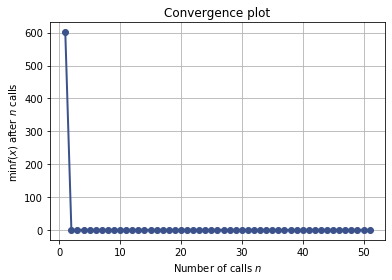

In [244]:
plt.figure()
plot_convergence(res_svm)
plt.show()

##### 5. Gaussian Process

In [245]:
params_space  = [Categorical([None], name='kernel'),
                 Categorical(['fmin_l_bfgs_b', 'adam'], name='optimizer'),
                 Real(1e-5, 1, "uniform", name='alpha')]

@use_named_args(params_space)
def gp_objective(**params):
    cls = GaussianProcessRegressor(**params)
    return objective_core(cls, X_train5_layer1, y_train5_layer1, **params)

In [246]:
res_gp = gp_minimize(gp_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_gp.fun

------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'adam', 'alpha': 0.8579470381665808, 'n_jobs': -1}
Score: 0.6006917310276624
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'adam', 'alpha': 0.38438786347562703, 'n_jobs': -1}
Score: 0.5988874772563902
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.27266356801716746, 'n_jobs': -1}
Score: 0.581930603667227
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'adam', 'alpha': 0.4799823726033337, 'n_jobs': -1}
Score: 0.591317673861811
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'adam', 'alpha': 0.3374027864556643, 'n_jobs': -1}
Score: 0.5842464408362563
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.957155587401457, 'n_jobs': -1}
Score: 0.5834220350298289
------ Sampling new data point ------
Params: {'kernel': None, 'o

/Users/pluto/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'adam', 'alpha': 1.0, 'n_jobs': -1}
Score: 0.6026802659173476
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.5909570539697264, 'n_jobs': -1}
Score: 0.5621976130304439
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.591013451918379, 'n_jobs': -1}
Score: 0.5893260427908604
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.5915014370073172, 'n_jobs': -1}
Score: 0.5836844777602299
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.5908930062230393, 'n_jobs': -1}
Score: 0.588186388366562
------ Sampling new data point ------
Params: {'kernel': None, 'optimizer': 'fmin_l_bfgs_b', 'alpha': 0.9029051261912061, 'n_jobs': -1}
Score: 0.5779013473154508
------ Sampling new data point ------
Params: {'kernel

'Best score=0.5622'

In [247]:
print("Optimal parameters")
params_gp = {}
for param, value in zip(params_space, res_gp.x):
    print(f"Param: {param.name}, value: {value}")
    
    params_gp[param.name] = value
    
model_gp = GaussianProcessRegressor(**params_gp)
model_gp.fit(X_train5_layer1.values, y_train5_layer1.values)


Optimal parameters
Param: kernel, value: None
Param: optimizer, value: fmin_l_bfgs_b
Param: alpha, value: 0.5909570539697264


GaussianProcessRegressor(alpha=0.5909570539697264, copy_X_train=True,
                         kernel=None, n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

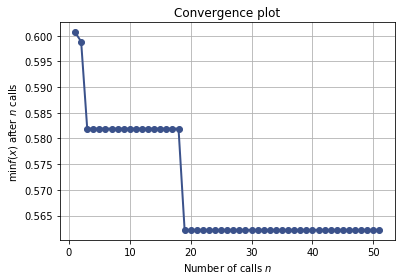

In [248]:
plt.figure()
plot_convergence(res_gp)
plt.show()

##### 6. Deep Learning

##### 6b. Neural Network

In [249]:
params_space  = [Integer(5, 50, name='hidden_layer_sizes'),
                 Categorical(['relu', 'logistic'], name='activation'),
                 Categorical(['adam', 'sgd', 'lbfgs'], name='solver'),
                 Real(1e-4, 1, "uniform", name='alpha'),
                 Real(1e-3, 0.1, "uniform", name='learning_rate_init'),
                 Categorical(['constant', 'adaptive'], name='learning_rate')]

@use_named_args(params_space)
def mlp_objective(**params):
    cls = MLPRegressor(**params)
    return objective_core(cls, X_train6_layer1, y_train6_layer1, **params)


res_mlp = gp_minimize(mlp_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_mlp.fun

------ Sampling new data point ------
Params: {'hidden_layer_sizes': 32, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.8472670136102473, 'learning_rate_init': 0.06273280598181127, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7049759228444312
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 18, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.47771735080961786, 'learning_rate_init': 0.08140470414877385, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7490959123791107
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 23, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.6482070548639922, 'learning_rate_init': 0.03745591244421426, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7390246677594293
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 11, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.8009306609044465, 'learning_rate_init': 0.05252727047556929, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7373300011971624
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 37, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.7586397627599252, 'learning_rate_init': 0.011484853111591423, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7789446573996855
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 13, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.13530465158811153, 'learning_rate_init': 0.033089959771528205, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7177439502140605
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 15, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.45000499491223656, 'learning_rate_init': 0.06169328233052913, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.74813788711757
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 9, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.17099249417753157, 'learning_rate_init': 0.036457064529982985, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.716873277118783
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 32, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.6343106305515395, 'learning_rate_init': 0.09593597759382755, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7504506944457893
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 34, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.41442715136754626, 'learning_rate_init': 0.04799505272655289, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7178950436367367
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7826586180158284
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 50, 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.0, 'learning_rate_init': 0.020499166471829828, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.8322907337873485
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 45, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 1.0, 'learning_rate_init': 0.0635513582437201, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.6832896995689769
------ Sampling new data point ------
Params: {'hidden_layer_siz

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 42, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.8508967071219429
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 34, 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.0, 'learning_rate_init': 0.07288230589175931, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.8040687690900947
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 9, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7661458464755654
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 50, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7393493325526522
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 50, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0001, 'learning_rate_init': 0.0647514936692031, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.8220461734755306
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.06030719626530069, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7185282811444168
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 12, 'activation': 'relu', 'solver': 'sgd', 'alpha': 1.0, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7297507776591926
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.8364452144765756
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 1.0, 'learning_rate_init': 0.07614966522089012, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7130223894738604
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 50, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.9683017001014415
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07669249044813713, 'learning_rate_init': 0.04560390396888446, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.716026168660392
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activatio

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.2656066296215313, 'learning_rate_init': 0.08327058483333004, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7104984555307166
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 50, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.06646028501573875, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7275231785324947
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 50, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.5481983049211103, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7682206922120708
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.31188845271722593, 'learning_rate_init': 0.04288348247074048, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7189814932981456
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'relu', 'solver': 'sgd', 'alpha': 1.0, 'learning_rate_init': 0.04749559264275824, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.726921160213584
------ Sampling new data point ------
Params: {'hidden_lay

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 5, 'activation': 'relu', 'solver': 'sgd', 'alpha': 1.0, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7922238171223244
------ Sampling new data point ------


/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 5, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.2189422833343022, 'learning_rate_init': 0.05831565593122194, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.705702290324842
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 50, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 1.0, 'learning_rate_init': 0.056189894913330325, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7968290710644327
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.6804702570850729, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7247922140750217
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.6667598547989619, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7307171685287712
------ Sampling new data point ------
Params: {'hidden_layer_siz

/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/pluto/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Params: {'hidden_layer_sizes': 50, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.11993891992561025, 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'n_jobs': -1}
Score: 0.7135121411832683
------ Sampling new data point ------
Params: {'hidden_layer_sizes': 5, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.6123397242238722, 'learning_rate_init': 0.0715072999283983, 'learning_rate': 'constant', 'n_jobs': -1}
Score: 0.7446945442642252


'Best score=0.6833'

In [250]:
print("Optimal parameters")
params_mlp = {}
for param, value in zip(params_space, res_mlp.x):
    print(f"Param: {param.name}, value: {value}")
    
    params_mlp[param.name] = value
    
model_mlp = MLPRegressor(**params_mlp)
model_mlp.fit(X_train6_layer1.values, y_train6_layer1.values)


Optimal parameters
Param: hidden_layer_sizes, value: 45
Param: activation, value: logistic
Param: solver, value: lbfgs
Param: alpha, value: 1.0
Param: learning_rate_init, value: 0.0635513582437201
Param: learning_rate, value: constant


MLPRegressor(activation='logistic', alpha=1.0, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=45, learning_rate='constant',
             learning_rate_init=0.0635513582437201, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

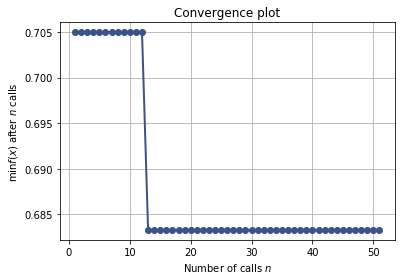

In [251]:
plt.figure()
plot_convergence(res_mlp)
plt.show()

#### Comparing metrics for all single cases on train layer 1 data

In [252]:
models = dict(LGBM=[model_lgb, X_train1_layer1, y_train1_layer1, 'LGBM'], 
              LASSO=[model_lasso, X_train2_layer1, y_train2_layer1, 'LASSO'], 
              RFE=[model_rfe, X_train3_layer1, y_train3_layer1, 'RFE'], 
              SVM=[model_svr, X_train4_layer1, y_train4_layer1, 'SVM'], 
              GP=[model_gp, X_train5_layer1, y_train5_layer1, 'GP'], 
              ANN=[model_mlp, X_train6_layer1, y_train6_layer1, 'ANN'])

In [253]:
for key, val in models.items():
    ypred = val[0].predict(val[1])*y_train_std + y_train_mean
    
    ytrue = val[2]*y_train_std + y_train_mean
    
    print(val[3])
    diagnostic_stats(ytrue, ypred)

LGBM
RMSE: 3.134, R^2: 0.611, MBE: 0.000, IOAD: 0.922
LASSO
RMSE: 3.218, R^2: 0.523, MBE: 0.000, IOAD: 0.911
RFE
RMSE: 2.750, R^2: 0.658, MBE: -0.003, IOAD: 0.936
SVM
RMSE: 2.255, R^2: 0.737, MBE: 0.109, IOAD: 0.950
GP
RMSE: 1.719, R^2: 0.853, MBE: 0.001, IOAD: 0.970
ANN
RMSE: 3.032, R^2: 0.611, MBE: 0.003, IOAD: 0.925


##### Predictions using layer 1 models for layer 2 data

In [254]:
y_pred1_layer2 = model_lgb.predict(X_train_layer2)
y_pred2_layer2 = model_lasso.predict(X_train_layer2)
y_pred3_layer2 = model_rfe.predict(X_train_layer2)
y_pred4_layer2 = model_svr.predict(X_train_layer2)
y_pred5_layer2 = model_gp.predict(X_train_layer2)
y_pred6_layer2 = model_mlp.predict(X_train_layer2)


y_pred1_test = model_lgb.predict(X_test)
y_pred2_test = model_lasso.predict(X_test)
y_pred3_test = model_rfe.predict(X_test)
y_pred4_test = model_svr.predict(X_test)
y_pred5_test = model_gp.predict(X_test)
y_pred6_test = model_mlp.predict(X_test)

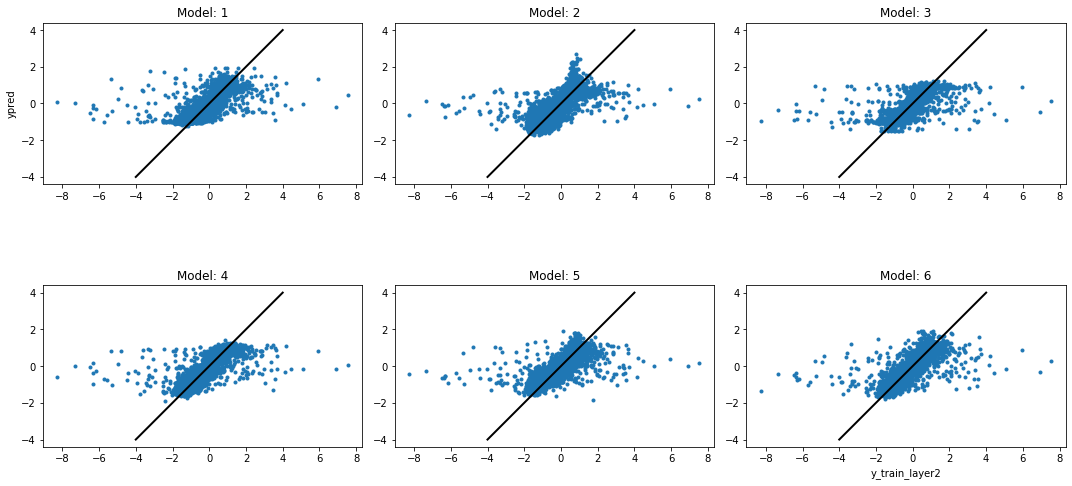

In [255]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax = ax.flatten()
for i, preds in enumerate([y_pred1_layer2, y_pred2_layer2, 
                           y_pred3_layer2, y_pred4_layer2, 
                           y_pred5_layer2, y_pred6_layer2]):
    ax[i].plot(y_train_layer2, preds, '.')
    ax[i].set_title('Model: {0}'.format(i+1))
    ax[i].plot([-4,4],
               [-4,4], 'k', lw=2)
    ax[i].set_aspect('equal')
ax[0].set_ylabel('ypred')
plt.xlabel('y_train_layer2')
plt.tight_layout()

### Layer 2 training

In [256]:
# Train data
Yfeatures_train_layer2 = pd.DataFrame(np.array([y_pred1_layer2.squeeze(), y_pred2_layer2.squeeze(),
                                                y_pred3_layer2.squeeze(), y_pred4_layer2.squeeze(),
                                                y_pred5_layer2.squeeze(), y_pred6_layer2.squeeze()]).T)
Yfeatures_train_layer2.shape, y_train_layer2.shape

((3824, 6), (3824,))

##### ENSEMBLE: Training on layer 2 (Yfeatures(Layer1 Model(X)), y_train) 

In [257]:
Yfeatures_train_layer2.shape, y_train_layer2.shape

((3824, 6), (3824,))

In [258]:
pd.concat([Yfeatures_train_layer2, y_train_layer2.reset_index()], axis=1).to_csv('train_layer2.csv')

In [259]:
params_space  = [Integer(2, 10, name='num_leaves'),
          Categorical(['regression'], name = "objective"),
          Integer(2, 10, name='min_data_in_leaf'),
          Real(10**-4, 10**0, "uniform", name='learning_rate'),
          Integer(100, 1001, name='n_estimators')]

@use_named_args(params_space)
def lgb_objective(**params):
    cls = lgb.LGBMRegressor(**params)
    return objective_core(cls, Yfeatures_train_layer2, y_train_layer2, **params)

res_lgb_l2 = gp_minimize(lgb_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_lgb_l2.fun

------ Sampling new data point ------
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.8472670136102473, 'n_estimators': 662, 'n_jobs': -1}
Score: 0.8677748944675026
------ Sampling new data point ------
Params: {'num_leaves': 5, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.27272902895065526, 'n_estimators': 530, 'n_jobs': -1}
Score: 0.7786971616843991
------ Sampling new data point ------
Params: {'num_leaves': 8, 'objective': 'regression', 'min_data_in_leaf': 5, 'learning_rate': 0.836095155661024, 'n_estimators': 404, 'n_jobs': -1}
Score: 0.8485663839226801
------ Sampling new data point ------
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.1404367453346039, 'n_estimators': 884, 'n_jobs': -1}
Score: 0.7613090679199516
------ Sampling new data point ------
Params: {'num_leaves': 6, 'objective': 'regression', 'min_data_in_leaf': 6, 'learning_rate': 0.6789116421659485, 

------ Sampling new data point ------
Params: {'num_leaves': 6, 'objective': 'regression', 'min_data_in_leaf': 7, 'learning_rate': 0.0001, 'n_estimators': 189, 'n_jobs': -1}
Score: 1.0066429595249085
------ Sampling new data point ------
Params: {'num_leaves': 4, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.3635036473082827, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.7267471131239333
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 8, 'learning_rate': 0.8306831407351037, 'n_estimators': 951, 'n_jobs': -1}
Score: 0.7070213154403869
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.26609273243258547, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.6792308617545894
------ Sampling new data point ------
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 1.0, 'n_estimators': 160, 'n_

'Best score=0.6760'

Optimal parameters
Param: num_leaves, value: 2
Param: objective, value: regression
Param: min_data_in_leaf, value: 2
Param: learning_rate, value: 0.1540740136522795
Param: n_estimators, value: 100


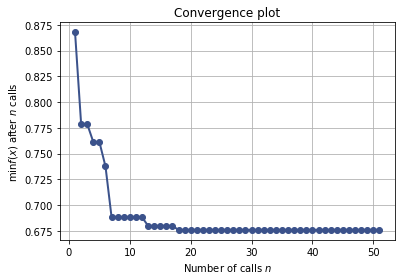

In [260]:
print("Optimal parameters")
params_lgb_l2 = {}
for param, value in zip(params_space, res_lgb_l2.x):
    print(f"Param: {param.name}, value: {value}")
    
    params_lgb_l2[param.name] = value
    
model_layer2_lgb_ensemble = lgb.LGBMRegressor(**params_lgb_l2)
model_layer2_lgb_ensemble.fit(Yfeatures_train_layer2, y_train_layer2)

plt.figure()
plot_convergence(res_lgb_l2)
plt.show()

##### SINGLE: Training directly on layer 2 (X_train, y_train)

In [261]:
params_space  = [Integer(2, 10, name='num_leaves'),
          Categorical(['regression'], name = "objective"),
          Integer(2, 10, name='min_data_in_leaf'),
          Real(10**-4, 10**0, "uniform", name='learning_rate'),
          Integer(100, 1001, name='n_estimators')]

@use_named_args(params_space)
def lgb_objective(**params):
    cls = lgb.LGBMRegressor(**params)
    return objective_core(cls, X_train_layer2, y_train_layer2, **params)

res_lgb_l2_single = gp_minimize(lgb_objective, params_space, n_calls=N_CALLS, random_state=0)

"Best score=%.4f" % res_lgb_l2_single.fun

------ Sampling new data point ------
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.8472670136102473, 'n_estimators': 662, 'n_jobs': -1}
Score: 0.8250282435537176
------ Sampling new data point ------
Params: {'num_leaves': 5, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.27272902895065526, 'n_estimators': 530, 'n_jobs': -1}
Score: 0.7410216118763316
------ Sampling new data point ------
Params: {'num_leaves': 8, 'objective': 'regression', 'min_data_in_leaf': 5, 'learning_rate': 0.836095155661024, 'n_estimators': 404, 'n_jobs': -1}
Score: 0.8647104964211638
------ Sampling new data point ------
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.1404367453346039, 'n_estimators': 884, 'n_jobs': -1}
Score: 0.744843276920967
------ Sampling new data point ------
Params: {'num_leaves': 6, 'objective': 'regression', 'min_data_in_leaf': 6, 'learning_rate': 0.6789116421659485, '

------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.14353846389015806, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.6999688686321863
------ Sampling new data point ------
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.11732808602572405, 'n_estimators': 1001, 'n_jobs': -1}
Score: 0.7422721186436787
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.713350233194874, 'n_estimators': 1001, 'n_jobs': -1}
Score: 0.7099823015125063
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.4058414778309005, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.7003952722113308
------ Sampling new data point ------
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.25309215784131

'Best score=0.6849'

Optimal parameters
Param: num_leaves, value: 2
Param: objective, value: regression
Param: min_data_in_leaf, value: 2
Param: learning_rate, value: 0.1540740136522795
Param: n_estimators, value: 100


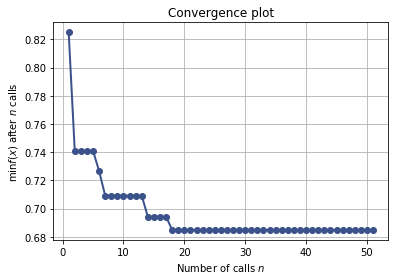

In [262]:
print("Optimal parameters")
params_lgb_l2_single = {}
for param, value in zip(params_space, res_lgb_l2.x):
    print(f"Param: {param.name}, value: {value}")
    
    params_lgb_l2_single[param.name] = value
    
model_layer2_lgb_single = lgb.LGBMRegressor(**params_lgb_l2_single)
model_layer2_lgb_single.fit(X_train_layer2, y_train_layer2)

plt.figure()
plot_convergence(res_lgb_l2_single)
plt.show()

## Test


In [263]:
Yfeatures_test = pd.DataFrame(np.array([y_pred1_test.squeeze(), y_pred2_test.squeeze(),
                                        y_pred3_test.squeeze(), y_pred4_test.squeeze(),
                                        y_pred5_test.squeeze(), y_pred6_test.squeeze()]).T)
print(Yfeatures_test.shape, y_test.shape)

(1367, 6) (1367,)


In [264]:
pd.concat([Yfeatures_test, y_test.reset_index()], axis=1).to_csv('test_layer2.csv')

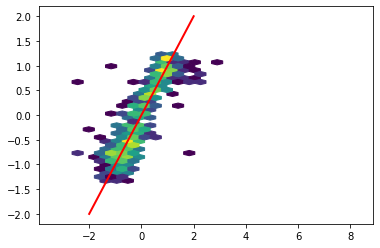

In [265]:
plt.hexbin(y_test, model_layer2_lgb_ensemble.predict(Yfeatures_test), mincnt=2, gridsize=30, bins='log')
plt.plot([-2,2], [-2,2], 'r', lw=2)

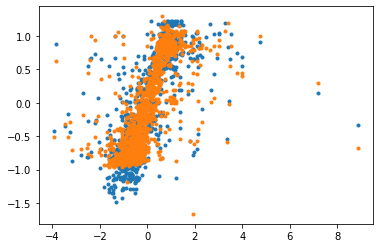

In [266]:
plt.plot(y_test, model_layer2_lgb_ensemble.predict(Yfeatures_test),'.')
plt.plot(y_test, model_layer2_lgb_single.predict(X_test),'.')

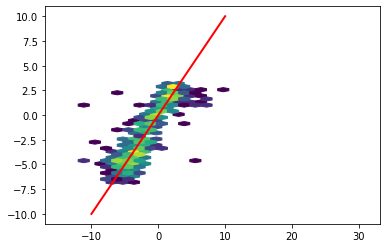

In [267]:
plt.hexbin(y_test*y_test_std + y_test_mean, 
           model_layer2_lgb_ensemble.predict(Yfeatures_test)*y_test_std + y_test_mean, mincnt=2, 
           gridsize=30, bins='log')
plt.plot([-10,10], [-10,10], 'r', lw=2)

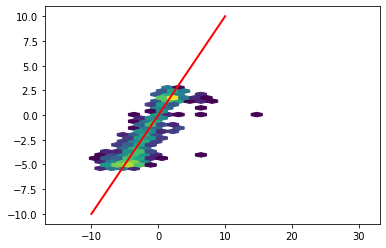

In [268]:
plt.hexbin(y_test*y_test_std + y_test_mean, model_layer2_lgb_single.predict(X_test)*y_test_std + y_test_mean, 
           mincnt=2, 
           gridsize=30, bins='log')
plt.plot([-10,10], [-10,10], 'r', lw=2)

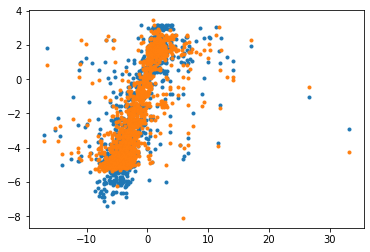

In [269]:
plt.plot(y_test*y_test_std + y_test_mean, model_layer2_lgb_ensemble.predict(Yfeatures_test)*y_test_std + y_test_mean,'.')
plt.plot(y_test*y_test_std + y_test_mean, model_layer2_lgb_single.predict(X_test)*y_test_std + y_test_mean,'.')

In [270]:
print('Ensemble')
y_test_pred_ensemble = model_layer2_lgb_ensemble.predict(Yfeatures_test)
diagnostic_stats(y_test*y_test_std + y_test_mean, y_test_pred_ensemble*y_test_std + y_test_mean);

Ensemble
RMSE: 2.820, R^2: 0.481, MBE: 0.057, IOAD: 0.904


In [271]:
print('Singe Model')
y_test_pred_single = model_layer2_lgb_single.predict(X_test)
diagnostic_stats(y_test*y_test_std + y_test_mean, y_test_pred_single*y_test_std + y_test_mean);

Singe Model
RMSE: 2.851, R^2: 0.470, MBE: 0.203, IOAD: 0.900


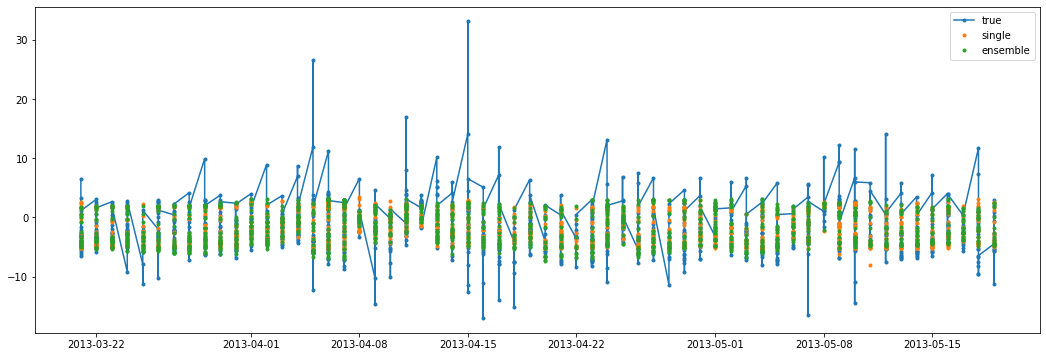

In [272]:
plt.figure(figsize=(18,6))
plt.plot(df_test.index.date, df_test[yvar]*y_test_std + y_test_mean, '.-', label='true')
plt.plot(df_test.index.date, y_test_pred_single*y_test_std + y_test_mean, '.', label='single')
plt.plot(df_test.index.date, y_test_pred_ensemble*y_test_std + y_test_mean, '.', label='ensemble')
plt.legend()

(-5, 5)

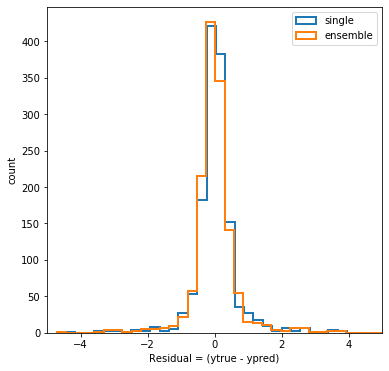

In [273]:
plt.figure(figsize=(6,6))
plt.hist(df_test[yvar] - y_test_pred_single, histtype='step', lw=2, label='single', bins=50)
plt.hist(df_test[yvar] - y_test_pred_ensemble, histtype='step', lw=2, label='ensemble', bins=50)
plt.xlabel('Residual = (ytrue - ypred)')
plt.ylabel('count')
plt.legend()
plt.xlim(-5,5)